<a href="https://colab.research.google.com/github/sachaRfd/Circle-Detector/blob/main/Circle_locator_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Explaining the functions given by SlingShot: 

In [135]:
# Imports: 
from functions import *
!pip install livelossplot
!pip install tensorboard


import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from livelossplot import PlotLosses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


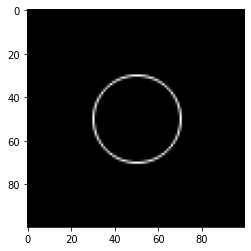

In [136]:
# Draw Circle: 

# create a numpy array of zeros with shape (100, 100)
img = np.zeros((100, 100))

# draw a circle with center (50, 50) and radius 20 in the numpy array
img = draw_circle(img, 50, 50, 20)

# show the numpy array with the circle using matplotlib
plt.imshow(img, cmap='gray')
plt.show()

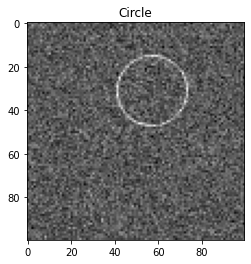

CircleParams(row=31, col=57, radius=16)


In [137]:
# Random Circle with noise: 
# generate a random circle with radius between 10 and 30, centered at a random point
# with a noise level of 0.2
img, circle_params = noisy_circle(img_size=100, min_radius=10, max_radius=30, noise_level=0.2)

# show the generated circle
show_circle(img)

# print the center point and radius of the circle
print(circle_params)


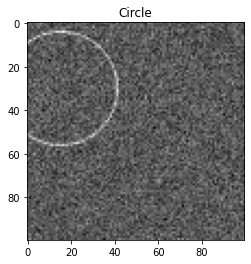

CircleParams(row=30, col=15, radius=26)


In [138]:
# generate a random circle with radius between 10 and 30, centered at a random point
# with a noise level of 0.2
img, circle_params = noisy_circle(img_size=100, min_radius=10, max_radius=30, noise_level=0.2)

# show the generated circle
show_circle(img)

# print the center point and radius of the circle
print(circle_params)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


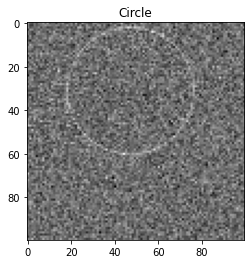

Row: 31, Col: 47, Radius: 29


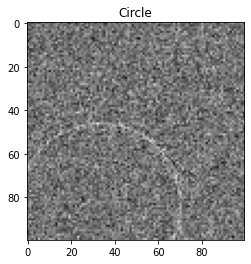

Row: 83, Col: 33, Radius: 37


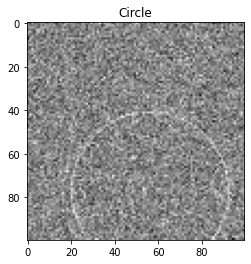

Row: 77, Col: 56, Radius: 36


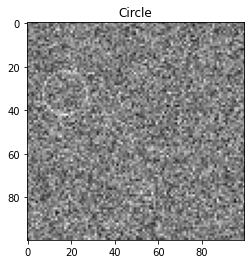

Row: 32, Col: 17, Radius: 10


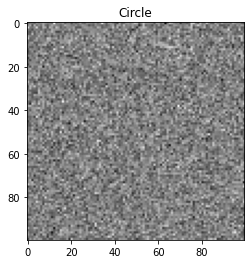

Row: 0, Col: 64, Radius: 11


In [139]:
# Create a generator with default parameters
example_generator = generate_examples()

# Generate 5 examples
for i in range(5):
    # Get the next example from the generator
    img, params = next(example_generator)
    
    # Display the image and its parameters
    show_circle(img)
    print(f"Row: {params.row}, Col: {params.col}, Radius: {params.radius}")

In [140]:
# Define two circles
circle1 = CircleParams(row=50, col=50, radius=20)
circle2 = CircleParams(row=60, col=60, radius=15)

# Calculate the intersection over union of the circles
iou_value = iou(circle1, circle2)

# Print the result
print(f"Intersection over union: {iou_value}")

Intersection over union: 0.8296882167250156


First off, let's create the custom dataset class:

In [141]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset for the circle images
class CircleDataset(Dataset):
    def __init__(self, noise_level, img_size, min_radius=None, max_radius=None):
        self.generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)
        self.length = 1000  # Set the length to a fixed number, e.g., 1000

    def __getitem__(self, idx):
        img, params = next(self.generator)
        return img, torch.tensor(params)

    def __len__(self):
        return self.length
        
# Define the train dataset and dataloader
train_dataset = CircleDataset(noise_level=0.5, img_size=100, min_radius=10, max_radius=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the test dataset and dataloader
test_dataset = CircleDataset(noise_level=0.5, img_size=100, min_radius=10, max_radius=50)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


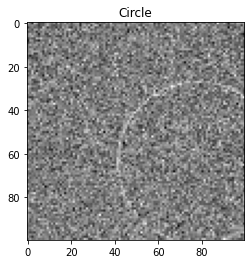

tensor([22, 33, 29])


In [142]:
show_circle(next(iter(train_loader))[0][0])
print(next(iter(train_loader))[1][0])

# Now For the steps: 
- create data set and loaders: 

In [143]:
class CircleDataset(Dataset):
    def __init__(self, noise_level, img_size, min_radius=None, max_radius=None):
        self.generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
        self.length = 100  # Started with 100


    def __getitem__(self, idx):
        img, params = next(self.generator)
        img_tensor = self.transform(img)
        params_tensor = torch.tensor([params.row, params.col, params.radius])
        return img_tensor, params_tensor

    def __len__(self):
        return self.length

# Define the train and test datasets and dataloaders
train_dataset = CircleDataset(noise_level=0.1, img_size=100, min_radius=10, max_radius=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CircleDataset(noise_level=0.1, img_size=100, min_radius=10, max_radius=50)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Let's get a basic model running: 

In [144]:
class CircleDetector(nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        x = x.float()
        x = self.conv(x)
        x = x.view(-1, 512 * 6 * 6)
        x = self.fc(x)
        return x


Let's setup our train, test and evaluate functions: 

In [145]:
# def iou50_loss(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#     ious = []
#     for a, b in zip(output, target):
#         a_params = CircleParams(*a.cpu().detach().numpy())
#         b_params = CircleParams(*b.cpu().numpy())
#         r1, r2 = a_params.radius, b_params.radius
#         d = torch.norm(torch.tensor([a_params.row, a_params.col]) - torch.tensor([b_params.row, b_params.col]))
#         if d > r1 + r2:
#             iou_val = torch.tensor(0.0, device=output.device)
#         elif d <= abs(r1 - r2):
#             iou_val = torch.tensor(1.0, device=output.device)
#         else:
#             a_area = torch.tensor(a_params.area(), device=output.device)
#             b_area = torch.tensor(b_params.area(), device=output.device)
#             intersection = (torch.pow(r1, 2) * torch.acos(torch.div(torch.pow(d, 2) + torch.pow(r1, 2) - torch.pow(r2, 2), 2 * d * r1))) + (torch.pow(r2, 2) * torch.acos(torch.div(torch.pow(d, 2) + torch.pow(r2, 2) - torch.pow(r1, 2), 2 * d * r2))) - (0.5 * torch.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2)))
#             iou_val = intersection / (a_area + b_area - intersection)
#         if iou_val >= 0.5:
#             ious.append(1)
#         else:
#             ious.append(0)
#     iou_tensor = torch.tensor(ious, dtype=torch.float32, device=output.device, requires_grad=True)
#     return 1 - iou_tensor.mean()


# from torch.utils.tensorboard import SummaryWriter

# def train(model, train_loader, optimizer, device, writer=None, global_step=None):
#     model.train()
#     train_loss = 0
#     for i, (img, params) in enumerate(train_loader):
#         img, params = img.to(device), params.to(device)
#         optimizer.zero_grad()
#         output = model(img)
#         loss = iou50_loss(output, params)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     if writer:
#         writer.add_scalar('Loss/Train', avg_train_loss, global_step=global_step)
    
#     return avg_train_loss


# def test(model, test_loader, device):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (img, params) in enumerate(test_loader):
#             img, params = img.to(device), params.to(device)
#             output = model(img)
#             loss = iou50_loss(output, params)
#             test_loss += loss.item()
#     return test_loss / len(test_loader)

In [153]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    liveplot = PlotLosses()
    for i, (img, params) in enumerate(train_loader):
        img, params = img.to(device), params.to(device)
        img = img.float().to(device)
        params = params.float().to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, params)
        loss.backward()
        optimizer.step()
    return loss / len(train_loader.dataset)


def test(model, test_loader, criterion, device, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, params) in enumerate(test_loader):
            img, params = img.to(device), params.to(device)
            output = model(img)
            loss = criterion(output, params)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch}, Average test loss: {avg_test_loss}")    
    return avg_test_loss
  
def evaluate(model, noise_level):
  transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
  example_generator = generate_examples(noise_level=noise_level, img_size=100, min_radius=10, max_radius=50)
  img_test, params_test = next(example_generator)
  show_circle(img_test)
  print('Real Parameters for above Circle', params_test)
  model.eval()
  eval_params = model(transform(img_test).reshape((1, 1, 100, 100)).to(device))
  eval_params = eval_params.cpu().detach().numpy()
  print('Predicted Parameters {}'.format(eval_params))
  plot_predicted_circle(x = eval_params[0][1], y=eval_params[0][0], radius = eval_params[0][2])  # as you can see the order is wrong because my y axis is actually the first in the array

def plot_predicted_circle(x, y, radius):  # Function to plot circle from model: 
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, 100)
    ax.set_ylim(100, 0)  # Flip y axis

    # generate data for a circle with the given radius
    t = np.linspace(0, 2*np.pi, 100)
    circle_x = radius * np.cos(t) + x
    circle_y = radius * np.sin(t) + y

    # plot the circle
    ax.plot(circle_x, circle_y)
    ax.set_aspect('equal', 'box')
    plt.show()


# Training Setup: 

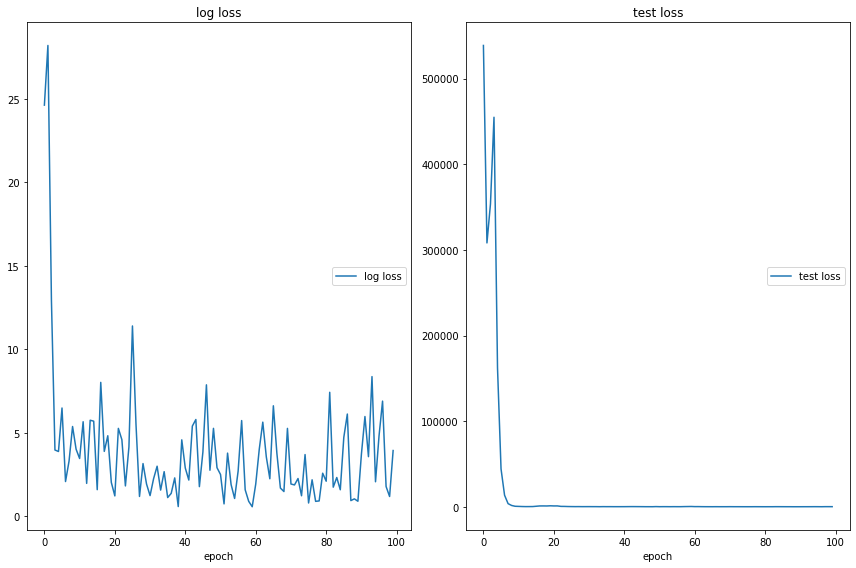

log loss
	log loss         	 (min:    0.576, max:   28.197, cur:    3.941)
test loss
	test loss        	 (min:   59.539, max: 538734.227, cur:  137.968)


In [151]:
from livelossplot import PlotLosses
import matplotlib.pyplot as plt

# Create the model
model = CircleDetector().to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params}")

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 100
liveloss = PlotLosses()  # Setup for loss Curve

for epoch in range(num_epochs):
    # Train the model and get the train loss
    logs = {}
    train_loss = train(model, train_loader, optimizer, criterion, device)
    logs['' + 'log loss'] = train_loss.item()
    # Evaluate the model
    test_loss = test(model, test_loader, criterion, device, epoch)
    logs['' + 'test loss'] = test_loss
    
    # Update the liveplot and draw
    liveloss.update(logs)
    liveloss.draw()

# Evaluate the model: 

Using parameters: noise_level=0, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


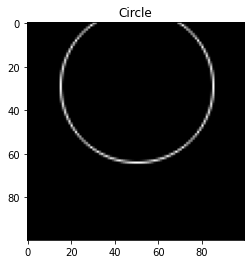

Real Parameters for above Circle CircleParams(row=29, col=50, radius=35)
Predicted Parameters [[ 9.327051 38.54507  31.440626]]


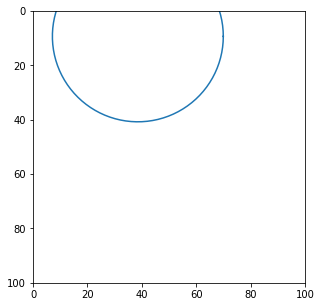

In [160]:
evaluate(model, noise_level=0)

# My training idea: 
- start with circle with little noise --> train until loss converges  / Or even no noise with code: # Draw Circle: img = np.zeros((100, 100));img = draw_circle(img, 50, 50, 20); plt.imshow(img, cmap='gray')
plt.show()
- make dataloader with more noise
- Train egain
- Repeat multiple times

- Potentially also look into smaller radii that do not go out of the picture
- Make function inside evaluate that checks IoU50
  - Potentially look into implement IoU50 into Loss


- Look into YoloV5/V1 model architecture. 